In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [3]:
import glob
import os

file_list = glob.glob(os.path.join(os.getcwd(), "", "*.txt"))
text_ru = []

for file_path in file_list:
    with open(file_path,'r',encoding='utf8') as f_input:
        text_ru.append(f_input.read())
text_ru_str = ''.join(text_ru).lower()
text_ru_str = re.sub('[^а-я ]','', text_ru_str)

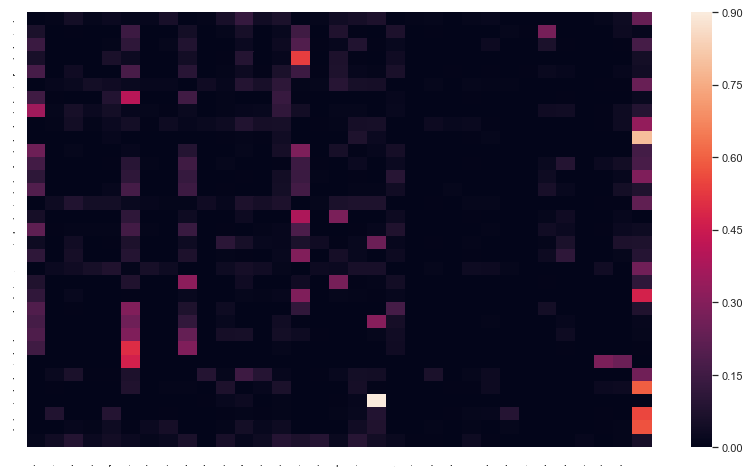

In [4]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS_RU = {l: i for i, l in enumerate(RUSSIAN)}

probabilities_ru = np.zeros((len(RUSSIAN), len(RUSSIAN)))

for cp, cn in zip(text_ru_str[:-1], text_ru_str[1:]):
    probabilities_ru[POS_RU[cp], POS_RU[cn]] += 1
    
probabilities_ru = (probabilities_ru / probabilities_ru.sum(axis=1)[:, None])

df_ru = pd.DataFrame(probabilities_ru, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

plt.figure(figsize=(14,8))
sns.heatmap(df_ru)
plt.show()

In [8]:
start = POS_RU['п']
end = POS_RU['р']
prior = 1. / len(RUSSIAN)
proba_total = 0
for c in RUSSIAN:
    for cc in RUSSIAN:
        proba = prior * probabilities_ru[start, POS_RU[c]] *probabilities_ru[POS_RU[c],POS_RU[cc]] *probabilities_ru[POS_RU[cc], end]
        proba_total = proba_total+proba
        #if proba > 0:
        #    print(''.join(['п', c, cc, 'р']), proba)
print('Вероятность встретить строку, начинающуюся с буквы П и заканчивающуюся на Р =', proba_total)

Вероятность встретить строку, начинающуюся с буквы П и заканчивающуюся на Р = 0.0009779681063459857


In [21]:
#сгенерить слово из 8 букв начиная с буквы Б
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS_RU[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities_ru[index])
    s.append(next_char)

print (''.join(s))

букредани


## Оценка ряда с помощью HMM

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [23]:
dow_close = pd.read_csv("weekly-closings-of-the-dowjones-.csv", delimiter=',')
dow_close.head()

,Week,"Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [27]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM

In [29]:
values = np.array(dow_close.iloc[:,1]).reshape(-1,1)

In [30]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -894.2620483582117
2 -820.6341453620655
3 -786.8375332667717
4 -752.0201472668957
5 -737.118137007309
6 -729.5671112589276
7 -713.7233991717127
8 -702.1057754504707
9 -690.9838068209382
10 -681.9992419659592
11 -682.8908577110998
12 -675.2607639286153
13 -661.769673543582


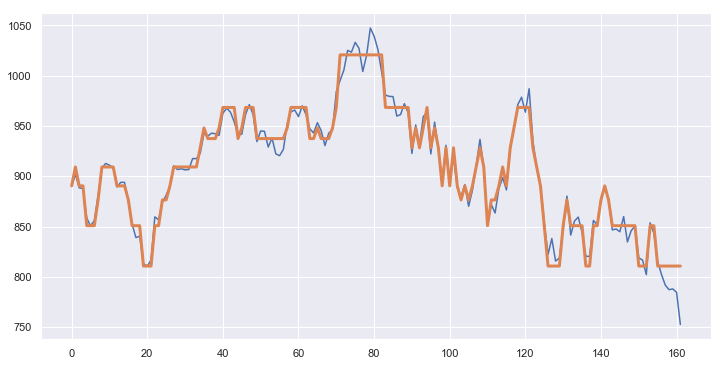

In [31]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

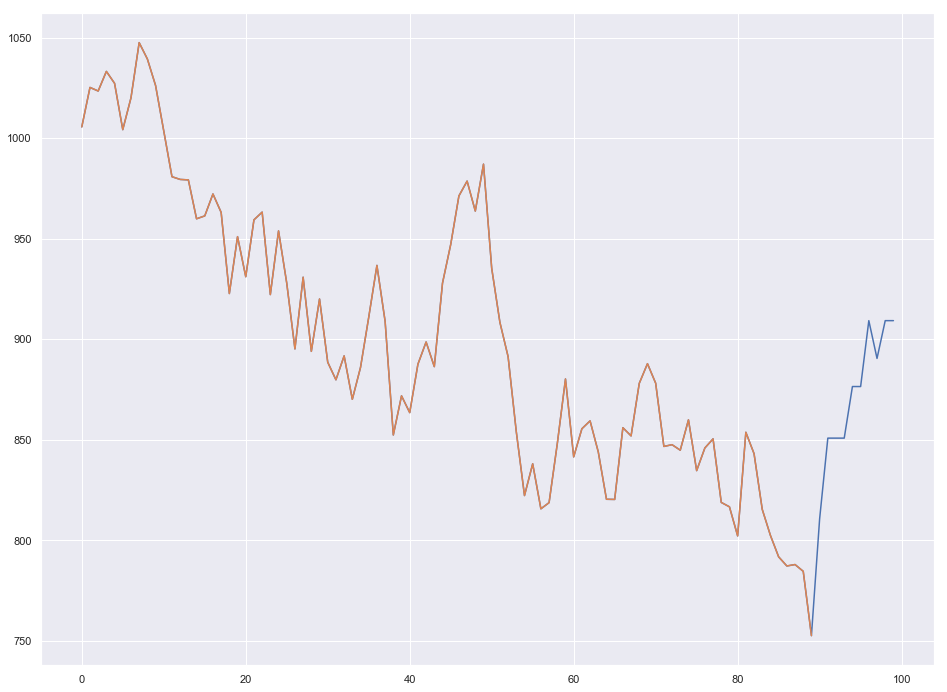

In [32]:
cur_value = labels[-1]
predictions = []
for _ in range(10):
    cur_value = np.random.choice(10, p=model.transmat_[cur_value])
    predictions.append(model.means_[cur_value])
new_series = np.concatenate((values, np.array(predictions)))
plt.figure(figsize=(16,12))
plt.plot(new_series[-100:])
plt.plot(values[-90:])
plt.show()